In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load data
data = pd.read_excel("final_dataset.xlsx")

# Data Cleaning and Preparation (Adapt to your specific needs)
data.columns = data.columns.str.replace(' ', '')

# --- Calculate Weighted Average ---
import numpy as np # Import numpy for using np.nan and np.array

def calculate_weighted_average(values, weights): # Add weights as an argument
    """Calculates weighted average, handling all-zero/NaN cases."""
    non_na_values = [val for val in values if not pd.isna(val)]
    if not non_na_values:
        return np.nan

    # Adjust weights to correspond to non-na values
    adjusted_weights = np.array([weights[i] for i, val in enumerate(values) if not pd.isna(val)])
    adjusted_values = np.array(non_na_values)

    # Calculate weighted average using adjusted values and weights
    weighted_values = adjusted_values * adjusted_weights
    return np.sum(weighted_values) / np.sum(adjusted_weights)

#Define weights - assuming 4 seasons of data
weights = np.array([0.5, 0.25, 0.15, 0.1]) # Adjust if you have different number of seasons

stats_to_calculate = [
    "MP", "Starts", "Min", "TotalMins/90", "Gls", "Ast",
    "Non-PenaltyGoals", "PenaltiesScored", "PenaltiesAttempted", "YellowCards",
    "RedCards", "Gls/90", "Ast/90", "GandA/90", "Non-PenaltyGoals/90",
    "GlsandAst-ScoredPenalties/90", "xG", "Non-PenaltyxG", "xA",
    "Non-penaltyxGandxA", "xG/90", "xA/90", "xGandxA/90", "Non-PenaltyxG/90",
    "Non-PenaltyxGandxA/90", "TotalShots", "TotalShotsonTarget",
    "ShotsonTarget%", "Shots/90", "ShotsonTarget/90", "Goals/Shots",
    "Goals/ShotsonTarget", "AvgShotDistance-yds", "FreekickShots",
    "Non-PenaltyxG/Shots", "GoalsScoredminusxG",
    "Non-PenaltyGoalsScoredminusNon-PenaltyxG", "Shot-CreatingActions",
    "Shot-CreatingActions/90", "PassesLeadingtoShotAttempt",
    "Set-PieceLeadingtoShotAttempt", "DribblesLeadingtoShotAttempt",
    "ShotsLeadingtoShotAttempt", "FoulsDrawnLeadingtoShotAttempt",
    "DefensiveActionsLeadingtoShotAttempt", "GoalCreatingActions",
    "GoalCreatingActions/90", "PassesLeadingtoGoals",
    "Set-PieceLeadingtoGoals", "DribblesLeadingtoGoals",
    "ShotsLeadingtoGoals", "FoulsDrawnLeadingtoGoals",
    "DefensiveActionsLeadingtoGoals", "Touches",
    "TouchesinDefensivePenaltyBox", "TouchesinDefensive3rd",
    "TouchesinMidfield3rd", "TouchesinAttacking3rd",
    "TouchesinAttackingPenaltyBox", "TouchesinOpen-play",
    "TotalSuccessfulDribbles", "TotalAttemptedDribbles",
    "DribbleSuccess%", "Totalno.ofPlayersDribblesPast",
    "TotalNutmegs", "TotalCarries", "TotalDistanceCarriedtheBall",
    "TotalDistanceCarriedtheBallinForwardDirection",
    "TotalCarriesinForwardDirection", "CarriesintoFinalThird",
    "CarriesintoAttackingPenaltyBox", "TotalFailedAttemptsatControllingBall",
    "NumberofTimesTackledwhenDribbling",
    "NumberofTimesPlayerwasPassTarget", "NumberofTimesReceivedPass",
    "%ofTimesSuccessfullyReceivedPass", "ProgressivePassesReceived",
    "PassesCompleted-Allpass-types", "PassesAttempted-Allpass-types",
    "PassCompletion%-Allpass-types", "TotalDistanceofCompletedPasses-AllPass-types",
    "TotalDistanceofCompletedProgressivePasses-AllPass-types",
    "PassesCompleted-ShortPasses", "PassesAttempted-ShortPasses",
    "PassCompletion%-ShortPasses", "PassesCompleted-MediumPasses",
    "PassesAttempted-MediumPasses", "PassCompletion%-MediumPasses",
    "PassesCompleted-LongPasses", "PassesAttempted-LongPasses",
    "PassCompletion%-LongPasses", "TotalAssists", "xGAssisted",
    "AssistminusxGAssisted", "CompletedpassesthatenterFinal3rd",
    "CompletedpassesthatenterPenaltyBox",
    "CompletedCrossesthatenterPenaltyBox", "TotalCompletedProgressivePasses",
    "TotalNumberofPlayersTackled", "TotalTacklesWon",
    "TacklesinDefensive3rd", "TacklesinMidfield3rd", "TacklesinAttacking3rd",
    "NumberofDribblersTackled", "TimesDribbledPastandTotalTackles",
    "%ofDribblersTackled", "NumberofTimesDribbledPast",
    "NumberofPressingActions", "TimesSquadgainedPossessionwithin5secondsofPressingActions",
    "SuccessfulPressure%", "NumberofPressesinDefensiveThird",
    "NumberofPressesinMidfieldThird", "NumberofPressesinAttackingThird",
    "TotalDefensiveBlocks", "TotalShotsBlocked", "GoalSavingBlocks",
    "TimesblockedaPass", "TotalInterceptions",
    "TotalPlayersTackledandTotalInterceptions", "TotalClearances",
    "MistakesleadingtoOpponentShots", "2ndYellowCards", "FoulsCommitted",
    "FoulsDrawn", "Offsides", "Crosses", "Interceptions",
    "PenaltyKicksWon", "PenaltiesConceded", "OwnGoals",
    "TotalLooseBallsRecovered", "AerialDuelWon", "AerialDuelLost",
    "%AerialDuelsWon"
]


for stat in stats_to_calculate:
    stat_cols = [col for col in data.columns if col.startswith(stat + "(")]

    # Pass the weights to the function
    data[stat + "_Weighted_Avg"] = data[stat_cols].apply(lambda row: calculate_weighted_average(row.values, weights[:len(row.values)]), axis=1)

data = data.fillna(0)

data['ContractYearsLeft'] = data['ContractYearsLeft'].replace('fail', 0).astype(int)

data = data.sort_values(['Age', 'ContractYearsLeft'], ascending=[False, False])
data = data.groupby(['Player', 'Squad(20/21)']).first().reset_index()

cleaned_player_data = data.iloc[:, :8].join(data.iloc[:, 549:])

position_mapping = {'Goalkeeper': 0, 'Defender': 1, 'midfield': 2, 'attack': 3}
cleaned_player_data['Position'] = cleaned_player_data['Position'].map(position_mapping)

<ipython-input-21-15795502bfa8>:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stat + "_Weighted_Avg"] = data[stat_cols].apply(lambda row: calculate_weighted_average(row.values, weights[:len(row.values)]), axis=1)
<ipython-input-21-15795502bfa8>:100: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[stat + "_Weighted_Avg"] = data[stat_cols].apply(lambda row: calculate_weighted_average(row.values, weights[:len(row.values)]), axis=1)
<ipython-input-21-15795502bfa8>:100: PerformanceWarning: DataFrame is highly fragmented.

In [ ]:
cleaned_player_data.head()

,Player,Squad(20/21),Club,Age,Position,Nation,Value,ContractYearsLeft,Starts_Weighted_Avg,Min_Weighted_Avg,...,Offsides_Weighted_Avg,Crosses_Weighted_Avg,Interceptions_Weighted_Avg,PenaltyKicksWon_Weighted_Avg,PenaltiesConceded_Weighted_Avg,OwnGoals_Weighted_Avg,TotalLooseBallsRecovered_Weighted_Avg,AerialDuelWon_Weighted_Avg,AerialDuelLost_Weighted_Avg,%AerialDuelsWon_Weighted_Avg
0,Aaron Connolly,Brighton,Brighton &amp; Hove Albion,21,3,Ireland,6300000,3,10.666667,946.666667,...,10.00,3.666667,1.666667,1.333333,0.0,0.0,36.666667,12.00,36.0,25.400
1,Aaron Cresswell,West Ham,West Ham United,31,1,England,4500000,2,31.950000,2812.000000,...,0.95,79.200000,29.800000,0.000000,0.0,0.0,280.300000,42.05,31.3,57.625
2,Aaron Escandell,Granada,Granada CF,25,0,Spain,900000,2,4.333333,390.000000,...,0.00,0.000000,0.000000,0.000000,0.0,0.0,30.666667,0.00,0.0,0.000
3,Aaron Hickey,Bologna,Bologna FC 1909,19,1,Scotland,4500000,3,10.000000,758.000000,...,0.00,6.000000,12.000000,0.000000,0.0,0.0,79.000000,3.00,4.0,42.900
4,Aaron Lennon,0,Burnley FC,34,3,England,990000,1,10.600000,994.700000,...,0.20,15.600000,11.000000,0.400000,0.3,0.0,65.000000,4.40,12.4,22.880


In [ ]:
# prompt: find all column names for cleaned_player_data
cleaned_player_data = cleaned_player_data.drop(columns=['Player', 'Squad(20/21)'])
print(cleaned_player_data.columns.tolist())

['Club', 'Age', 'Position', 'Nation', 'Value', 'ContractYearsLeft', 'Starts_Weighted_Avg', 'Min_Weighted_Avg', 'TotalMins/90_Weighted_Avg', 'Gls_Weighted_Avg', 'Ast_Weighted_Avg', 'Non-PenaltyGoals_Weighted_Avg', 'PenaltiesScored_Weighted_Avg', 'PenaltiesAttempted_Weighted_Avg', 'YellowCards_Weighted_Avg', 'RedCards_Weighted_Avg', 'Gls/90_Weighted_Avg', 'Ast/90_Weighted_Avg', 'GandA/90_Weighted_Avg', 'Non-PenaltyGoals/90_Weighted_Avg', 'GlsandAst-ScoredPenalties/90_Weighted_Avg', 'xG_Weighted_Avg', 'Non-PenaltyxG_Weighted_Avg', 'xA_Weighted_Avg', 'Non-penaltyxGandxA_Weighted_Avg', 'xG/90_Weighted_Avg', 'xA/90_Weighted_Avg', 'xGandxA/90_Weighted_Avg', 'Non-PenaltyxG/90_Weighted_Avg', 'Non-PenaltyxGandxA/90_Weighted_Avg', 'TotalShots_Weighted_Avg', 'TotalShotsonTarget_Weighted_Avg', 'ShotsonTarget%_Weighted_Avg', 'Shots/90_Weighted_Avg', 'ShotsonTarget/90_Weighted_Avg', 'Goals/Shots_Weighted_Avg', 'Goals/ShotsonTarget_Weighted_Avg', 'AvgShotDistance-yds_Weighted_Avg', 'FreekickShots_Weig

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Create the OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # handle_unknown='ignore' for unseen values during prediction

# --- One-hot encode 'Club' ---
encoded_club = encoder.fit_transform(cleaned_player_data[['Club']])
encoded_club_df = pd.DataFrame(encoded_club, columns=encoder.get_feature_names_out(['Club']))
cleaned_player_data = cleaned_player_data.drop('Club', axis=1).join(encoded_club_df)  # Join encoded 'Club'

# --- One-hot encode 'Nation' ---
encoded_nation = encoder.fit_transform(cleaned_player_data[['Nation']])  # Fit and transform 'Nation'
encoded_nation_df = pd.DataFrame(encoded_nation, columns=encoder.get_feature_names_out(['Nation']))
cleaned_player_data = cleaned_player_data.drop('Nation', axis=1).join(encoded_nation_df)  # Join encoded 'Nation'


# --- Prepare All Data ---
all_players = cleaned_player_data.loc[:, cleaned_player_data.nunique() > 1]

# --- Data Preprocessing ---
scaler = StandardScaler()
X_all = all_players.drop('Value', axis=1)
y_all = all_players['Value']
X_all_scaled = scaler.fit_transform(X_all)

In [ ]:
# Define a custom RMSE metric
def root_mean_squared_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch [1/50], Train Loss: 245378667741849.0938, Train RMSE: 15664567.2509, Valid Loss: 127273733506447.2656, Valid RMSE: 11281566.1412


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Train Loss: 114984778048418.4219, Train RMSE: 10723095.5765, Valid Loss: 114397359953777.6875, Valid RMSE: 10695670.1927


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [3/50], Train Loss: 104268001647217.1875, Train RMSE: 10211170.4152, Valid Loss: 106583883312774.4375, Valid RMSE: 10323947.0621


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch [4/50], Train Loss: 92967318339103.1094, Train RMSE: 9641956.1208, Valid Loss: 100466518378399.7656, Valid RMSE: 10023298.7785


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [5/50], Train Loss: 86550451803764.9219, Train RMSE: 9303249.5039, Valid Loss: 95683716422224.0312, Valid RMSE: 9781805.4069


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [6/50], Train Loss: 82067794084574.6875, Train RMSE: 9059127.6539, Valid Loss: 91004659450180.9375, Valid RMSE: 9539636.2421


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch [7/50], Train Loss: 75301616774104.1562, Train RMSE: 8677650.4431, Valid Loss: 87805814201080.9844, Valid RMSE: 9370475.6195


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [8/50], Train Loss: 72436688498706.8125, Train RMSE: 8510974.5968, Valid Loss: 85383764797444.9062, Valid RMSE: 9240333.6171


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [9/50], Train Loss: 70792597877566.6094, Train RMSE: 8413833.7267, Valid Loss: 81977889777027.4062, Valid RMSE: 9054164.2648


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/50], Train Loss: 67479798422205.4922, Train RMSE: 8214608.8175, Valid Loss: 79556720656173.8594, Valid RMSE: 8919457.3575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [11/50], Train Loss: 63550864328568.2344, Train RMSE: 7971879.5991, Valid Loss: 77408272590347.0781, Valid RMSE: 8798197.0847


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch [12/50], Train Loss: 63907722605669.6484, Train RMSE: 7994230.5970, Valid Loss: 76172303705185.9531, Valid RMSE: 8727674.5375


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [13/50], Train Loss: 57939288122398.9844, Train RMSE: 7611786.1496, Valid Loss: 74461239773182.7500, Valid RMSE: 8629092.6765


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [14/50], Train Loss: 60096439302328.5156, Train RMSE: 7752189.3347, Valid Loss: 71892298950073.1875, Valid RMSE: 8478932.6578


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [15/50], Train Loss: 55797270659308.7969, Train RMSE: 7469757.0713, Valid Loss: 70471387319397.1094, Valid RMSE: 8394723.7796


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [16/50], Train Loss: 53207512401827.4453, Train RMSE: 7294347.9696, Valid Loss: 68620857804004.6094, Valid RMSE: 8283770.8088


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch [17/50], Train Loss: 55042495082569.1641, Train RMSE: 7419062.9447, Valid Loss: 67457511630082.9609, Valid RMSE: 8213252.2292


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [18/50], Train Loss: 49791145676348.5703, Train RMSE: 7056284.1266, Valid Loss: 65963381282391.2812, Valid RMSE: 8121784.3841


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [19/50], Train Loss: 53112489735342.4531, Train RMSE: 7287831.5758, Valid Loss: 64426147685957.4219, Valid RMSE: 8026590.0627


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [20/50], Train Loss: 49079392977739.3750, Train RMSE: 7005668.6675, Valid Loss: 64769731721252.5703, Valid RMSE: 8047964.4822


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [21/50], Train Loss: 44855599407894.3125, Train RMSE: 6697432.3031, Valid Loss: 63588125735792.1719, Valid RMSE: 7974216.3344


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [22/50], Train Loss: 45301061243314.8516, Train RMSE: 6730606.3144, Valid Loss: 63196051259163.0156, Valid RMSE: 7949594.3777


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [23/50], Train Loss: 45053556917487.6094, Train RMSE: 6712194.6392, Valid Loss: 62846047266696.1719, Valid RMSE: 7927549.9205


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [24/50], Train Loss: 45259320843241.2109, Train RMSE: 6727504.8044, Valid Loss: 61716194537973.2266, Valid RMSE: 7855965.4874


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targe

Epoch [25/50], Train Loss: 42499784760441.8438, Train RMSE: 6519185.9041, Valid Loss: 61443915614968.3125, Valid RMSE: 7838617.0050


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [26/50], Train Loss: 41218725616025.3672, Train RMSE: 6420181.1383, Valid Loss: 63332232050698.3047, Valid RMSE: 7958155.0545


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [27/50], Train Loss: 44683406171555.3359, Train RMSE: 6684564.7755, Valid Loss: 62516193165990.8984, Valid RMSE: 7906718.2639


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [28/50], Train Loss: 41623150956647.1562, Train RMSE: 6451600.6516, Valid Loss: 62229405940323.2578, Valid RMSE: 7888561.7613


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [29/50], Train Loss: 38201460343428.0938, Train RMSE: 6180732.9897, Valid Loss: 63508053674269.9453, Valid RMSE: 7969193.9953


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [30/50], Train Loss: 39947638139914.3359, Train RMSE: 6320414.3953, Valid Loss: 66267596344270.3359, Valid RMSE: 8140491.2139
Early stopping at epoch 30


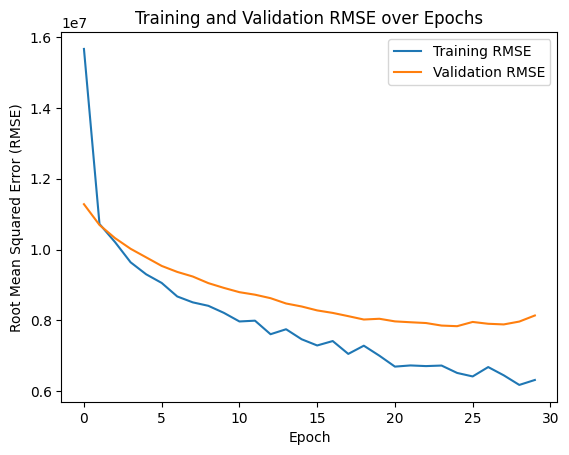

Final Validation RMSE: 8140491.213917747


In [ ]:
import tensorflow as tf  # Import TensorFlow with the 'tf' alias
import torch.nn as nn
import matplotlib.pyplot as plt  # Import matplotlib.pyplot
from sklearn.metrics import mean_squared_error
import torch
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all_scaled, y_all, test_size=0.2, random_state=42
)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all.values).float().view(-1, 1)  # Convert y_train to NumPy array first
X_test_tensor = torch.from_numpy(X_test_all).float()
y_test_tensor = torch.from_numpy(y_test_all.values).float().view(-1, 1)  # Convert y_test to NumPy array first


# Define the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nn.Sequential(
    nn.Linear(X_train_tensor.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(64, 1)
)

model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.05)

epochs = 50
early_stopping_patience = 5  # Number of epochs with no improvement to wait before stopping
best_valid_rmse = float('inf')  # Initialize with positive infinity

train_losses = []
valid_losses = []
train_rmses = []
valid_rmses = []

for e in range(epochs):
    running_train_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    # Training loop for one epoch
    model.train()
    for i in range(len(X_train_tensor)):
        train_features = X_train_tensor[i].to(device)
        train_labels = y_train_tensor[i].to(device)

        # Forward pass
        output = model(train_features.unsqueeze(0))  # Add batch dimension
        loss = criterion(output, train_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_train_loss += loss.item()

        # Collect predictions and labels for RMSE calculation
        all_train_preds.append(output.cpu().detach().numpy()[0][0])
        all_train_labels.append(train_labels.cpu().detach().item())

    # Calculate average training loss for the epoch
    epoch_train_loss = running_train_loss / len(X_train_tensor)
    train_losses.append(epoch_train_loss)

    # Calculate training RMSE
    train_rmse = np.sqrt(mean_squared_error(all_train_labels, all_train_preds))
    train_rmses.append(train_rmse)

    # Validation loop for one epoch
    model.eval()
    running_valid_loss = 0.0
    all_valid_preds = []
    all_valid_labels = []

    with torch.no_grad():
        for i in range(len(X_test_tensor)):
            valid_features = X_test_tensor[i].to(device)
            valid_labels = y_test_tensor[i].to(device)

            # Forward pass
            outputs = model(valid_features.unsqueeze(0))
            loss = criterion(outputs, valid_labels)
            running_valid_loss += loss.item()

            # Collect predictions and labels for RMSE calculation
            all_valid_preds.append(outputs.cpu().detach().numpy()[0][0])
            all_valid_labels.append(valid_labels.cpu().detach().item())

    # Calculate average validation loss for the epoch
    epoch_valid_loss = running_valid_loss / len(X_test_tensor)
    valid_losses.append(epoch_valid_loss)

    # Calculate validation RMSE
    valid_rmse = np.sqrt(mean_squared_error(all_valid_labels, all_valid_preds))
    valid_rmses.append(valid_rmse)

    # Early stopping implementation
    if valid_rmse < best_valid_rmse:
        best_valid_rmse = valid_rmse
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    print(f'Epoch [{e + 1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Valid Loss: {epoch_valid_loss:.4f}, Valid RMSE: {valid_rmse:.4f}')

    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {e+1}")
        break

# Plot training and validation RMSE over epochs
plt.plot(train_rmses, label='Training RMSE')
plt.plot(valid_rmses, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation RMSE over Epochs')
plt.legend()
plt.show()

# Print the last value of validation RMSE
print(f'Final Validation RMSE: {valid_rmses[-1]}')

In [ ]:
!pip install --upgrade scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error #Import the mean_squared_error from sklearn.metrics

linear_model_all = LinearRegression()
linear_model_all.fit(X_train_all, y_train_all)
linear_pred_all = linear_model_all.predict(X_test_all)
linear_rmse_all = mean_squared_error(y_test_all, linear_pred_all)

# --- Train and Evaluate Random Forest on All Players ---

rf_model_all = RandomForestRegressor(random_state=42)
rf_model_all.fit(X_train_all, y_train_all)
rf_pred_all = rf_model_all.predict(X_test_all)
rf_rmse_all = mean_squared_error(y_test_all, rf_pred_all)

# --- Train and Evaluate Lasso Regression on All Players ---

lasso_model_all = LassoCV(cv=10, random_state=42)
lasso_model_all.fit(X_train_all, y_train_all)
lasso_pred_all = lasso_model_all.predict(X_test_all)
lasso_rmse_all = mean_squared_error(y_test_all, lasso_pred_all)

# Print results
print("\nAll Players:")
print(f"MLP RMSE: {valid_rmses[-1]}")
print(f"Linear Regression RMSE: {linear_rmse_all}")
print(f"Random Forest RMSE: {rf_rmse_all}")
print(f"Lasso Regression RMSE: {lasso_rmse_all}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55287883752192.0, tolerance: 33066754951648.68
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39252695336224.0, tolerance: 33066754951648.68
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 154097180742400.0, tolerance: 33066754951648.68
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarni


All Players:
MLP RMSE: 8140491.213917747
Linear Regression RMSE: 89981387893489.36
Random Forest RMSE: 87579049769836.55
Lasso Regression RMSE: 71670386858636.92


In [ ]:
man_utd_players = cleaned_player_data[cleaned_player_data['Club_Manchester United'] == 1]
# --- Prepare Data for Prediction ---
man_utd_players_features = man_utd_players.drop('Value', axis=1)
man_utd_players_scaled = scaler.transform(man_utd_players_features)  # Use the same scaler as during training
man_utd_tensor = torch.from_numpy(man_utd_players_scaled).float()
with torch.no_grad():
    model.eval()  # Set model to evaluation mode
    man_utd_predictions = []
    for i in range(len(man_utd_tensor)):
        player_features = man_utd_tensor[i].to(device)
        predicted_value = model(player_features.unsqueeze(0)).cpu().detach().numpy()[0][0]
        man_utd_predictions.append(predicted_value)

# --- Add predictions to DataFrame ---
man_utd_players['Predicted_Value'] = man_utd_predictions
pd.options.display.float_format = '{:.2f}'.format
# --- Print or display the results ---
print(man_utd_players[['Age', 'Value', 'Predicted_Value']])

      Age     Value  Predicted_Value
8      23  36000000      45216016.00
73     28  18000000       7584109.00
106    19  16200000      21789900.00
170    25  40500000      54189864.00
272    26  81000000      79682416.00
352    36  40500000      73098320.00
419    30  16200000      14421037.00
428    24  19800000      20025224.00
462    22   9000000      22714676.00
479    24  27000000      24612744.00
501    34   5400000      14418610.00
535    27  13500000       8033106.00
636    28  19800000      32023822.00
729    28  45000000      43847760.00
812    21  90000000      87965312.00
895    28  19800000      26318094.00
1007   33   3600000       3931051.50
1124   38    225000        371022.94
1205   26  37800000      37814244.00
1264   23  76500000      69763056.00
1305   19  45000000      48553808.00
1467   33   7200000      13867313.00
1577   28  54000000      38794836.00
1603   29   4500000       6383873.00
1643   28  63000000      40327700.00
1787   24  31500000      37441784.00
1

<ipython-input-57-787fa50b7220>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  man_utd_players['Predicted_Value'] = man_utd_predictions


In [ ]:
data[data['Club'] == 'Manchester United']

,Player,Squad(20/21),Club,Age,Position,Nation,Value,ContractYearsLeft,League,MP(20/21),...,Offsides_Weighted_Avg,Crosses_Weighted_Avg,Interceptions_Weighted_Avg,PenaltyKicksWon_Weighted_Avg,PenaltiesConceded_Weighted_Avg,OwnGoals_Weighted_Avg,TotalLooseBallsRecovered_Weighted_Avg,AerialDuelWon_Weighted_Avg,AerialDuelLost_Weighted_Avg,%AerialDuelsWon_Weighted_Avg
8,Aaron Wan-Bissaka,Manchester Utd,Manchester United,23,Defender,England,36000000,3,Premier League,34.0,...,1.200000,54.000000,60.200000,0.000000,0.400000,0.0,257.700000,35.650000,29.700000,53.765000
73,Alex Telles,Manchester Utd,Manchester United,28,Defender,Brazil,18000000,3,Premier League,9.0,...,1.000000,27.000000,12.000000,0.000000,0.000000,0.0,59.000000,11.000000,10.000000,52.400000
106,Amad Diallo,Manchester Utd,Manchester United,19,attack,Cote d'Ivoire,16200000,4,Premier League,3.0,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,11.000000,1.000000,2.000000,33.300000
170,Anthony Martial,Manchester Utd,Manchester United,25,attack,France,40500000,3,Premier League,22.0,...,12.200000,20.950000,4.950000,2.550000,0.000000,0.0,74.550000,16.800000,31.750000,37.520000
272,Bruno Fernandes,Manchester Utd,Manchester United,26,midfield,Portugal,81000000,4,Premier League,37.0,...,2.666667,68.000000,17.000000,0.666667,0.666667,0.0,189.666667,9.333333,32.000000,21.033333
352,Cristiano Ronaldo,Juventus,Manchester United,36,attack,Portugal,40500000,2,Premier League,33.0,...,31.550000,47.500000,7.450000,1.600000,0.000000,0.0,115.200000,29.400000,26.300000,53.545000
419,David de Gea,Manchester Utd,Manchester United,30,Goalkeeper,Spain,16200000,2,Premier League,26.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,118.900000,0.000000,0.000000,0.000000
428,Dean Henderson,Manchester Utd,Manchester United,24,Goalkeeper,England,19800000,4,Premier League,13.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,99.666667,0.333333,0.000000,100.000000
462,Diogo Dalot,Milan,Manchester United,22,Defender,Portugal,9000000,2,Premier League,21.0,...,1.444444,25.444444,12.000000,0.000000,0.166667,0.0,72.444444,16.666667,5.500000,81.722222
479,Donny van de Beek,Manchester Utd,Manchester United,24,midfield,Netherlands,27000000,4,Premier League,19.0,...,0.000000,4.000000,7.000000,1.000000,0.000000,0.0,44.000000,3.000000,4.000000,42.900000


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Value'].plot(kind='hist', bins=20, title='Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['ContractYearsLeft'].plot(kind='hist', bins=20, title='ContractYearsLeft')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Squad(20/21)').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Position').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='index', y='Age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Age', y='Value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Value', y='ContractYearsLeft', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='ContractYearsLeft', y='MP(20/21)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Squad(20/21)')):
  _plot_series(series, series_name, i)
  fig.legend(title='Squad(20/21)', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Position')):
  _plot_series(series, series_name, i)
  fig.legend(title='Position', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Age')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Squad(20/21)')):
  _plot_series(series, series_name, i)
  fig.legend(title='Squad(20/21)', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Value')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Value']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Position')):
  _plot_series(series, series_name, i)
  fig.legend(title='Position', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Value')

from matplotlib import pyplot as plt
_df_14['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['ContractYearsLeft'].plot(kind='line', figsize=(8, 4), title='ContractYearsLeft')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Position'].value_counts()
    for x_label, grp in _df_18.groupby('Squad(20/21)')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Squad(20/21)')
_ = plt.ylabel('Position')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Squad(20/21)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='index', y='Squad(20/21)', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Position'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='index', y='Position', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['Squad(20/21)'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='Age', y='Squad(20/21)', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['Position'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='Age', y='Position', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
print(cleaned_player_data.columns.tolist())

['Age', 'Position', 'Value', 'ContractYearsLeft', 'Starts_Weighted_Avg', 'Min_Weighted_Avg', 'TotalMins/90_Weighted_Avg', 'Gls_Weighted_Avg', 'Ast_Weighted_Avg', 'Non-PenaltyGoals_Weighted_Avg', 'PenaltiesScored_Weighted_Avg', 'PenaltiesAttempted_Weighted_Avg', 'YellowCards_Weighted_Avg', 'RedCards_Weighted_Avg', 'Gls/90_Weighted_Avg', 'Ast/90_Weighted_Avg', 'GandA/90_Weighted_Avg', 'Non-PenaltyGoals/90_Weighted_Avg', 'GlsandAst-ScoredPenalties/90_Weighted_Avg', 'xG_Weighted_Avg', 'Non-PenaltyxG_Weighted_Avg', 'xA_Weighted_Avg', 'Non-penaltyxGandxA_Weighted_Avg', 'xG/90_Weighted_Avg', 'xA/90_Weighted_Avg', 'xGandxA/90_Weighted_Avg', 'Non-PenaltyxG/90_Weighted_Avg', 'Non-PenaltyxGandxA/90_Weighted_Avg', 'TotalShots_Weighted_Avg', 'TotalShotsonTarget_Weighted_Avg', 'ShotsonTarget%_Weighted_Avg', 'Shots/90_Weighted_Avg', 'ShotsonTarget/90_Weighted_Avg', 'Goals/Shots_Weighted_Avg', 'Goals/ShotsonTarget_Weighted_Avg', 'AvgShotDistance-yds_Weighted_Avg', 'FreekickShots_Weighted_Avg', 'Non-Pe

In [ ]:
yamal_data = pd.DataFrame(columns=cleaned_player_data.columns, index=[0])
yamal_data['Age'] = 17
yamal_data['Position'] = 3
yamal_data['ContractYearsLeft'] = 4
yamal_data['Starts_Weighted_Avg'] = 38
yamal_data['Min_Weighted_Avg'] = 2957
yamal_data['TotalMins/90_Weighted_Avg'] = 25
yamal_data['Gls_Weighted_Avg'] = 7
yamal_data['Ast_Weighted_Avg'] = 9
yamal_data['Non-PenaltyGoals_Weighted_Avg'] = 7
yamal_data['PenaltiesScored_Weighted_Avg'] = 0
yamal_data['PenaltiesAttempted_Weighted_Avg'] = 0
yamal_data['YellowCards_Weighted_Avg'] = 6
yamal_data['RedCards_Weighted_Avg'] = 0
yamal_data['Gls/90_Weighted_Avg'] = 0.2
yamal_data['Ast/90_Weighted_Avg'] = 0.2
yamal_data['GandA/90_Weighted_Avg'] = 0.41
yamal_data['Non-PenaltyGoals/90_Weighted_Avg'] = 0.2
yamal_data['GlsandAst-ScoredPenalties/90_Weighted_Avg'] = 0.21
yamal_data['xG_Weighted_Avg'] = 0.21
yamal_data['Non-PenaltyxG_Weighted_Avg'] = 0.21
yamal_data['xA_Weighted_Avg'] = 5.1
yamal_data['Non-penaltyxGandxA_Weighted_Avg'] = 8.88
yamal_data['xG/90_Weighted_Avg'] = 0.21
yamal_data['xA/90_Weighted_Avg'] = 0.27
yamal_data['xGandxA/90_Weighted_Avg'] = 0.21
yamal_data['Non-PenaltyxG/90_Weighted_Avg'] = 0.21
yamal_data['Non-PenaltyxGandxA/90_Weighted_Avg'] = 0.47
yamal_data['TotalShots_Weighted_Avg'] = 44.79
yamal_data['TotalShotsonTarget_Weighted_Avg'] = 16.24
yamal_data['ShotsonTarget%_Weighted_Avg'] = 36.2
yamal_data['Shots/90_Weighted_Avg'] = 2.37
yamal_data['ShotsonTarget/90_Weighted_Avg'] = 0.86
yamal_data['Goals/Shots_Weighted_Avg'] = 0.09
yamal_data['Goals/ShotsonTarget_Weighted_Avg'] = 0.24
yamal_data['AvgShotDistance-yds_Weighted_Avg'] = 17.50
yamal_data['FreekickShots_Weighted_Avg'] = 0
yamal_data['Non-PenaltyxG/Shots_Weighted_Avg'] = 0.09
yamal_data['GoalsScoredminusxG_Weighted_Avg'] = -0.01
yamal_data['Non-PenaltyGoalsScoredminusNon-PenaltyxG_Weighted_Avg'] = -0.01
yamal_data['Shot-CreatingActions_Weighted_Avg'] = 83.53
yamal_data['Shot-CreatingActions/90_Weighted_Avg'] = 4.42
yamal_data['PassesLeadingtoShotAttempt_Weighted_Avg'] = 29.28
yamal_data['Set-PieceLeadingtoShotAttempt_Weighted_Avg'] = 0
yamal_data['DribblesLeadingtoShotAttempt_Weighted_Avg'] = 12
yamal_data['ShotsLeadingtoShotAttempt_Weighted_Avg'] = 3
yamal_data['FoulsDrawnLeadingtoShotAttempt_Weighted_Avg'] = 2
yamal_data['DefensiveActionsLeadingtoShotAttempt_Weighted_Avg'] = 0
yamal_data['GoalCreatingActions_Weighted_Avg'] = 13.98
yamal_data['GoalCreatingActions/90_Weighted_Avg'] = 0.74
yamal_data['PassesLeadingtoGoals_Weighted_Avg'] = 7
yamal_data['Set-PieceLeadingtoGoals_Weighted_Avg'] = 0
yamal_data['DribblesLeadingtoGoals_Weighted_Avg'] = 2
yamal_data['ShotsLeadingtoGoals_Weighted_Avg'] = 1
yamal_data['FoulsDrawnLeadingtoGoals_Weighted_Avg'] = 1
yamal_data['DefensiveActionsLeadingtoGoals_Weighted_Avg'] = 0
yamal_data['Touches_Weighted_Avg'] = 1139.05
yamal_data['TouchesinDefensivePenaltyBox_Weighted_Avg'] = 10.77
yamal_data['TouchesinDefensive3rd_Weighted_Avg'] = 91.28
yamal_data['TouchesinMidfield3rd_Weighted_Avg'] = 355.38
yamal_data['TouchesinAttacking3rd_Weighted_Avg'] = 712.52
yamal_data['TouchesinAttackingPenaltyBox_Weighted_Avg'] = 113.31
yamal_data['TouchesinOpen-play_Weighted_Avg'] = 1139.05
yamal_data['TotalSuccessfulDribbles_Weighted_Avg'] = 53.98
yamal_data['TotalAttemptedDribbles_Weighted_Avg'] = 123.51
yamal_data['DribbleSuccess%_Weighted_Avg'] = 43.8
yamal_data['Totalno.ofPlayersDribblesPast_Weighted_Avg'] = 60
yamal_data['TotalNutmegs_Weighted_Avg'] = 2
yamal_data['TotalCarries_Weighted_Avg'] = 790.56
yamal_data['TotalDistanceCarriedtheBall_Weighted_Avg'] = 5112.63
yamal_data['TotalDistanceCarriedtheBallinForwardDirection_Weighted_Avg'] = 3003.34
yamal_data['TotalCarriesinForwardDirection_Weighted_Avg'] = 94.85
yamal_data['CarriesintoFinalThird_Weighted_Avg'] = 60.27
yamal_data['CarriesintoAttackingPenaltyBox_Weighted_Avg'] = 44.05
yamal_data['TotalFailedAttemptsatControllingBall_Weighted_Avg'] = 41.74
yamal_data['NumberofTimesTackledwhenDribbling_Weighted_Avg'] = 44.82
yamal_data['NumberofTimesPlayerwasPassTarget_Weighted_Avg'] = 1230
yamal_data['NumberofTimesReceivedPass_Weighted_Avg'] = 894.68
yamal_data['%ofTimesSuccessfullyReceivedPass_Weighted_Avg'] = 68
yamal_data['ProgressivePassesReceived_Weighted_Avg'] = 150
yamal_data['PassesCompleted-Allpass-types_Weighted_Avg'] = 696.31
yamal_data['PassesAttempted-Allpass-types_Weighted_Avg'] = 873.60
yamal_data['PassCompletion%-Allpass-types_Weighted_Avg'] = 79.8
yamal_data['TotalDistanceofCompletedPasses-AllPass-types_Weighted_Avg'] = 9939
yamal_data['TotalDistanceofCompletedProgressivePasses-AllPass-types_Weighted_Avg'] = 2330.97
yamal_data['PassesCompleted-ShortPasses_Weighted_Avg'] = 441.28
yamal_data['PassesAttempted-ShortPasses_Weighted_Avg'] = 503.62
yamal_data['PassCompletion%-ShortPasses_Weighted_Avg'] = 88.0
yamal_data['PassesCompleted-MediumPasses_Weighted_Avg'] = 202.74
yamal_data['PassesAttempted-MediumPasses_Weighted_Avg'] = 262.72
yamal_data['PassCompletion%-MediumPasses_Weighted_Avg'] = 77.7
yamal_data['PassesCompleted-LongPasses_Weighted_Avg'] = 34.4
yamal_data['PassesAttempted-LongPasses_Weighted_Avg'] = 59.15
yamal_data['PassCompletion%-LongPasses_Weighted_Avg'] = 57.1
yamal_data['TotalAssists_Weighted_Avg'] = 9
yamal_data['xGAssisted_Weighted_Avg'] = 5.08
yamal_data['AssistminusxGAssisted_Weighted_Avg'] = -3.92
yamal_data['CompletedpassesthatenterFinal3rd_Weighted_Avg'] = 30.03
yamal_data['CompletedpassesthatenterPenaltyBox_Weighted_Avg'] = 40.11
yamal_data['CompletedCrossesthatenterPenaltyBox_Weighted_Avg'] = 12.43
yamal_data['TotalCompletedProgressivePasses_Weighted_Avg'] = 62.13
yamal_data['TotalNumberofPlayersTackled_Weighted_Avg'] = 50
yamal_data['TotalTacklesWon_Weighted_Avg'] = 28.61
yamal_data['TacklesinDefensive3rd_Weighted_Avg'] = 24.67
yamal_data['TacklesinMidfield3rd_Weighted_Avg'] = 11.62
yamal_data['TacklesinAttacking3rd_Weighted_Avg'] = 10.83
yamal_data['NumberofDribblersTackled_Weighted_Avg'] = 14.07
yamal_data['TimesDribbledPastandTotalTackles_Weighted_Avg'] = 33.33
yamal_data['%ofDribblersTackled_Weighted_Avg'] = 37.5
yamal_data['NumberofTimesDribbledPast_Weighted_Avg'] = 20
yamal_data['NumberofPressingActions_Weighted_Avg'] = 500
yamal_data['TimesSquadgainedPossessionwithin5secondsofPressingActions_Weighted_Avg'] = 120
yamal_data['SuccessfulPressure%_Weighted_Avg'] = 30
yamal_data['NumberofPressesinDefensiveThird_Weighted_Avg'] = 50
yamal_data['NumberofPressesinMidfieldThird_Weighted_Avg'] = 120
yamal_data['NumberofPressesinAttackingThird_Weighted_Avg'] = 150
yamal_data['TotalDefensiveBlocks_Weighted_Avg'] = 24.67
yamal_data['TotalShotsBlocked_Weighted_Avg'] = 0
yamal_data['GoalSavingBlocks_Weighted_Avg'] = 0
yamal_data['TimesblockedaPass_Weighted_Avg'] = 24.67
yamal_data['TotalInterceptions_Weighted_Avg'] = 14.86
yamal_data['TotalPlayersTackledandTotalInterceptions_Weighted_Avg'] = 43
yamal_data['TotalClearances_Weighted_Avg'] = 7.65
yamal_data['MistakesleadingtoOpponentShots_Weighted_Avg'] = 0
yamal_data['2ndYellowCards_Weighted_Avg'] = 0
yamal_data['FoulsCommitted_Weighted_Avg'] = 16.06
yamal_data['FoulsDrawn_Weighted_Avg'] = 36.21
yamal_data['Offsides_Weighted_Avg'] = 3
yamal_data['Crosses_Weighted_Avg'] = 60.55
yamal_data['Interceptions_Weighted_Avg'] = 14.86
yamal_data['PenaltyKicksWon_Weighted_Avg'] = 1.36
yamal_data['PenaltiesConceded_Weighted_Avg'] = 0
yamal_data['OwnGoals_Weighted_Avg'] = 0
yamal_data['TotalLooseBallsRecovered_Weighted_Avg'] = 71.09
yamal_data['AerialDuelWon_Weighted_Avg'] = 1.36
yamal_data['AerialDuelLost_Weighted_Avg'] = 7.65
yamal_data['%AerialDuelsWon_Weighted_Avg'] = 15.4
yamal_data['%AerialDuelsWon_Weighted_Avg'] = 15.4
yamal_data['%AerialDuelsWon_Weighted_Avg'] = 15.4
yamal_data['Club_FC Barcelona'] = 1  # One-hot encoding for FC Barcelona
yamal_data['Nation_Spain'] = 1  # One-hot encoding for Spain

for col in yamal_data.columns:
    if pd.isnull(yamal_data[col].values[0]):
        yamal_data[col] = 0

# Add Lamine Yamal's data to the existing DataFrame
cleaned_player_data = pd.concat([cleaned_player_data, yamal_data], ignore_index=True)
yamal_features = yamal_data.drop('Value', axis=1)

# Preprocess the features (using the same scaler as during training)
yamal_features_scaled = scaler.transform(yamal_features)

# Convert to PyTorch tensor
yamal_tensor = torch.from_numpy(yamal_features_scaled).float()

# Set model to evaluation mode
model.eval()

# Make prediction
with torch.no_grad():
    predicted_value = model(yamal_tensor.unsqueeze(0)).cpu().detach().numpy()[0][0]

print(f"Predicted Value for Lamine Yamal: {predicted_value}")

   Age  Position  Value  ContractYearsLeft  Starts_Weighted_Avg  \
0   17         3      0                  4                   38   

   Min_Weighted_Avg  TotalMins/90_Weighted_Avg  Gls_Weighted_Avg  \
0              2957                         25                 7   

   Ast_Weighted_Avg  Non-PenaltyGoals_Weighted_Avg  ...  Nation_Togo  \
0                 9                              7  ...            0   

   Nation_Tunisia  Nation_Turkey  Nation_Ukraine  Nation_United States  \
0               0              0               0                     0   

   Nation_Uruguay  Nation_Uzbekistan  Nation_Venezuela  Nation_Wales  \
0               0                  0                 0             0   

   Nation_Zimbabwe  
0                0  

[1 rows x 327 columns]
